# Simple Introduction to Deep Equilibrium Nets
## Notebook 1: no uncertainty and exogenous sampling of states

Notebook by [Marlon Azinovic](https://sites.google.com/view/marlonazinovic/home?authuser=0), [Luca Gaegauf](https://www.phd-finance.uzh.ch/en/People/phd-candidates/luca-gaegauf.html), and [Simon Scheidegger](https://sites.google.com/site/simonscheidegger/home), August 2023.
### Purpose of the notebook and economic model  
The notebook should serve as a simple introduction to [Deep Equilibirium Nets](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575), a deep learning based method introduced in [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575).  
To focus on the method, we are going to solve a simple optimal growth model with one representative agent, a simplified version of [Brock and Mirman (1972)](https://assoeconomiepolitique.org/wp-content/uploads/Brock-et-Mirman-1972.pdf).  

The planner aims to maximize her time-separable life time utility subject to her budget constraint:
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t} \ln\left(C_{t}\right)\\
\text{s.t.} \quad & K_{t+1} + C_{t} = Y_t + (1 - \delta) K_t
\end{align}
where $Y_t = K_{t} ^ \alpha$.

When we assume full depreciation, i.e. $\delta=1$, this particular problem has an analytical solution:

\begin{align}
K_{t+1} = \beta \alpha K_{t}^{\alpha}
\end{align}

We can numerically solve the above planner's problem by using any global solution algorithm such as the value function iteration or the time iteration collocation.  
However in this notebook, we demonstrate how the recursive equilibrium can be directly approximated by the deep neural net following [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575).  

Following [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575) the idea is to express the equilibrium conditions as a set of equations, which need to be satisfied in equilibrium and which characterize the optimal policies. Having such a set of equations and a candidate policy function, the extent to which the equations are satisfied can serve as a measure for the accuracy of the candidate policy funcion.  
The above problem can be formulated recursively, where the Bellman equation is given by
\begin{align}
V(K_t) &= \max_{K_{t+1}} \ln\left(C_{t}\right)+\beta V(K_{t+1})\\
\text{subject to: }C_t &= Y_t + (1 - \delta) K_t - K_{t+1}
\end{align}
Plugging in the budget constraint, we obtain
\begin{align}
V(K_t) &= \max_{K_{t+1}} \ln\left(Y_t + (1 - \delta) K_t - K_{t+1}\right)+\beta V(K_{t+1}).
\end{align}
$K_t$ denotes the **state** of the economy and $K_{t+1} = f(K_t)$ denotes the **policy**.
We are interested in approximating the policy $f(\cdot)$ with a neural network $\mathcal{N}(\cdot)$, such that $\mathcal{N}(K_t) \approx f(K_t) = K_{t+1} $.  
Taking the first order condition with respect to $K_{t+1}$, we obtain
\begin{align}
0 &= -\frac{1}{\underbrace{Y_t + (1 - \delta) K_t - K_{t+1}}_{=C_t}}+\beta \frac{d V(K_{t+1})}{d K_{t+1}}
\end{align}
Applying the [Envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem), we obtain
\begin{align}
\frac{d V(K_{t})}{d K_{t}} &= \frac{d}{d K_{t}}\ln\left(\underbrace{Y_t + (1 - \delta) K_t - K_{t+1}}_{=C_t}\right)\\
&= \frac{1}{C_t}\left(\frac{dY_t}{dK_t} + (1 - \delta)\right)\\
&= \frac{1}{C_t}\left(\underbrace{\alpha K_{t}^{\alpha - 1}}_{=:r_t} + (1 - \delta)\right)\\
&= \frac{1}{C_t}\left(r_t + 1 - \delta\right).
\end{align}
Applying this result to replace $\frac{d V(K_{t+1})}{d K_{t+1}}$ in the first order condition, we obtain
\begin{align}
0 &= -\frac{1}{C_t} + \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)
\end{align}
where 
\begin{align}
r_{t+1} &= \alpha K_{t+1}^{\alpha - 1}\\
C_t &= Y_t + (1 - \delta) K_t - K_{t+1}\\
C_{t+1} &= Y_{t+1} + (1 - \delta) K_{t+1} - K_{t+2}.
\end{align}
Our goal is now to find a policy function $f(\cdot)$, such that this equation is fullfilled for $K_{t+1}= f(K_t)$ and $K_{t+2}= f(K_{t+1})$.  
In order to be able to interpret the remaining errors in the equilibrium condition, we reformulate it such that deviations from 0 can be interpreted as relative consumption errors:
\begin{align}
0 &= -\frac{1}{C_t} + \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\\
\Leftrightarrow \frac{1}{C_t} &= \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right) \\
\Leftrightarrow C_t &= \frac{C_{t+1}}{\beta \left(1 - \delta + r_{t+1}\right)} \\
\Leftrightarrow 1 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)}  \\
\Leftrightarrow 0 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)} - 1.
\end{align}
We will encode this equation as the **loss function** to train the neural network.  
I.e. we will train the neural network $\mathcal{N}(\cdot)$ such that the implied policy fullfills the equation above.  
**Two remarks are in order:**
1. The above function can't be evaluated correctly if consumption or the level of capital are not positive. Since a neural network is initialized randomly, this is not guaranteed by itself. One way to address both reqirements is to approximate the savings rate $s_t$, such that $K_{t+1} = (1 - \delta) K_t + Y_t s_t =(1 - \delta) K_t +  Y_t \mathcal{N}(K_t)$. Since $Y_t$ is completely determined given the state $K_t$, this formulation still encodes the policy $K_{t+1}$, albeit slightly more indirectly. Using a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) we can ensure that $s_t\in(0, 1)$ and hence $K_{t+1}\geq 0$ and $C_t\geq 0$. In settings where this is not possible, measure would have to be taken (such as replacing negative numbers by small positive numbers and then adding a punishment term to the loss function), which help the neural network in the beginning of training.
2. An important question is for what states we want the above equation to hold. In principle we want to hold it for all possible states $K_t$, but in practice we need to focus on a finite space. In this notebook we startout in the simplest possible way and sample capital from an exogenous interval $\mathcal{K}=[\underline{K}, \overline{K}]$, for which we know that $f(\mathcal{K})\in \mathcal{K}$. When the state space is high dimensional, it is advantageous to sample more carefully, for example from the simulated path of the economy, i.e. from the ergodic distribution of states, that will be visited in equilibrium (see [Maliar et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0165188910002186) for more information on this topic). The next notebook will show how this can be done using [Deep Equilibrium Nets](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575), here we will sample exogenously for simplicity.

### Implementing the loss function

First, we need to import necessary python numerical libraries and tensorflow:

In [1]:
# Import necessary liblaries
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15

%matplotlib inline

print("Version of tensorflow is {}".format(tf.__version__))

Version of tensorflow is 2.12.0


We define the economic parameters, which are constant throughout and will be globals in this notebook.

In [2]:
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99  # Discount factor
delta = 1.0 # depreciation of capital

Since this model can be solved analytically for the full depreciation case, we implement the analytical solution (so that we can later check the solution found by the neural network).

In [3]:
def k_compute_infty(alpha, beta):
    """ Return the stationary point (or steady state) for full depreciation """
    return (1 / (beta * alpha))**(1/(alpha - 1))

k_infty = k_compute_infty(alpha, beta)
print("Stationary point is {:5f}".format(k_infty))


def Kplus_compute_analytic(K, alpha, beta):
    """ Return the optimal capital stock in the next period  for full depreciation """
    return alpha * beta * K**alpha


def c_compute(K, Knext, alpha, beta):
    """ Return the optimal consumption policy  for full depreciation """
    return Knext**alpha - Knext

Stationary point is 0.199482


#### Deep neural network 

In this section, we define the architecture of the deep neural net.  
Our goal is for the neural network to approximate the savings rate $s_t$, such that $K_{t+1} = Y_t s_t \approx Y_t \mathcal{N}\left(K_t \right)$.  
The neural network input is hence a 1-dimensional state $K_t$ and the output is the 1-dimensional savings rate $s_t$.


##### Hyper parameters

* Hyper parameter defines the architecture of the deep neural net. 

* Note that the purpose of this notebook is in the demonstration of the deep neural net. Detail analyses of the choice of hyper parameters are omitted and we use a densely connected feed forward neural network with two hidden layers as in [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575). Since we are approximating the savings rate, we want our architecture to ensure that $s_t \in (0, 1)$. We can do this by using a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) in the output layer. This is in the spirit of encoding prior knowledge based on economics directly into the neural network architecture (relatedly, [Kahou et al. (2021)](https://www.nber.org/papers/w28981) and [Han et al. (2022)](https://arxiv.org/abs/2112.14377) show how symmetry can be encoded into the neural-network architecture and [Azinovic and Žemlička (2023)](https://arxiv.org/abs/2303.14802) introduce market clearing neural network architectures.).  We assume the following structure of layers and activation functions: 
    * Layer 1: the input layer, 1 neuron corresponding to the capital stock $K_t$  
    * Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
    * Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
    * Layer 4: the output layer, 1 neuron corresponding to the savings rate $s_t$, such that $K_{t+1}=(1 - \delta) K_t + Y_t s_t$. We use a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6), ensuring that $s_t \in (0, 1)$.

In [4]:
# Layer setting
num_input = 1
num_hidden1 = 50
num_hidden2 = 50
num_output = 1
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [1, 50, 50, 1]


##### We define the neural network
We use [Keras](https://www.tensorflow.org/guide/keras) to define the neural network

In [5]:
# we use sigmod in the output layer so output is between 0 and 1
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation='sigmoid')
])

In [6]:
print(nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________
None


##### The batch dimension
Since neural networks are highly parallelizable, we typically do not want to evaluate the neural network for only a single state $K \in \mathbb{R}$, but for a vector of $N_{data}$ different capital levels $\mathbf{K} \in \mathbb{R}^{N_{data}\times 1}$. The output of the neural network is then a vector $\mathbf{s}\in \mathbb{R}^{N_{data}\times 1}$.  
The convention in deep learning is to have the different data samples on the 0-axis.

In [7]:
# test it
K_test = np.array([[1.], [2.]])

print("K_test = ", K_test)
print("nn prediction = ", nn(K_test))

K_test =  [[1.]
 [2.]]
nn prediction =  tf.Tensor(
[[0.47674853]
 [0.45359746]], shape=(2, 1), dtype=float32)


#### Implementing the cost function
As outlined above, we want to implement a cost-function which takes a vector of states $\mathbb{X}\in \mathbb{R}^{N_{data}\times 1}$ and a neural network $\mathcal{N}(\cdot)$, and then returns a vector of errors in the equilibrium conditions implied by the policy, which is encoded by the neural network.  
As explained above, the equilibrium condition is given by
\begin{align}
0 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)} - 1.
\end{align}
We use the [tf.function decorator](https://www.tensorflow.org/guide/function), which speeds up the evaluation of the cost function.

In [8]:
@tf.function
def compute_cost(X, nn):
    """ 
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state (this is trivial here because the state-space is one dimensional)
    K_t = X
    
    # compute output today
    Y_t = K_t ** alpha
    
    # use the neural network to predict the savings rate
    s_t = nn(X)
    
    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    C_t = Y_t - Y_t * s_t
    
    # get the state in t + 1
    X_next = K_tplus1
     
    # get output in the next period
    Y_tplus1 = K_tplus1 ** alpha
    
    # predict the savings policy in the next period
    s_tplus1 = nn(X_next)
    
    # predict capital in the next period
    C_tplus1 = Y_tplus1 - s_tplus1 * Y_tplus1
    
    # compute the return on capital in the next period
    R_tplus1 = alpha * K_tplus1 ** (alpha - 1.)
    
    # Define the relative Euler error
    errREE = 1 - C_tplus1 / (beta * C_t * (R_tplus1 + 1. - delta))
    
    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = tf.reduce_mean(errREE ** 2)

    return cost, errREE, C_t, C_tplus1, K_tplus1, R_tplus1

In [9]:
# let's try
X = tf.constant([[1.], [2.], [3.]])

print("cost = ", compute_cost(X, nn)[0])

cost =  tf.Tensor(0.04702626, shape=(), dtype=float32)


2023-08-22 09:59:52.273213: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Gradients
Now we define a function that, for given data X, computes the gradient of the loss w.r.t. the neural network parameters.  
This gradient will be used to update the neural network parameters into the direction which decreases the loss function.

In [10]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [11]:
X = tf.constant([[1.], [2.], [3.]])

loss, grads = grad(X, nn)

print("loss = ", loss)
print("grads = ", grads)

loss =  tf.Tensor(0.04702626, shape=(), dtype=float32)
grads =  [<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.11547543, -0.01038845,  0.        , -0.1129524 ,  0.        ,
         0.11983992, -0.21576825,  0.        , -0.03477114,  0.00218517,
         0.        , -0.0653811 ,  0.        ,  0.        , -0.10520238,
         0.        ,  0.02281937,  0.        , -0.05034017, -0.08998965,
        -0.02726902,  0.07724744,  0.        , -0.18890744,  0.12158421,
        -0.07447688,  0.        ,  0.07717402,  0.        ,  0.        ,
         0.        ,  0.        ,  0.07788353, -0.07593924,  0.        ,
         0.        ,  0.18159758,  0.01939724,  0.        ,  0.        ,
         0.        ,  0.        ,  0.01214245,  0.10742073,  0.        ,
        -0.04681066, -0.09275888, -0.08581329,  0.        ,  0.07058492]],
      dtype=float32)>, <tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 0.04473956, -0.00402488,  0.        , -0.04376205,  0.        ,
        0.04

#### Optimizer
We now define an optimizer, essentially an improved version of SGD

In [16]:
learning_rate = 0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

## Sampling data
we make a function to generate training data.
Here we just sample exogenously from an interval.

In [13]:
def get_training_data(k_lb, k_ub, n_data):
    X = tf.random.uniform(
    shape = [n_data, 1],
    minval=k_lb,
    maxval=k_ub,
    dtype=tf.dtypes.float32)
    return X

## Training
We iteratively generate training data and update the neural network

#=================================================================
episode = 0, loss [log10] = -0.8953810930252075


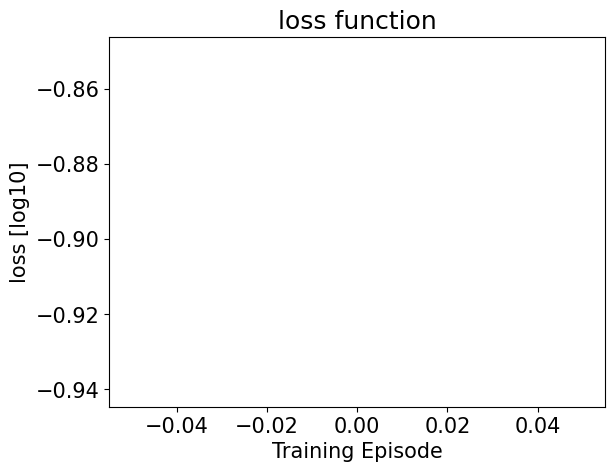

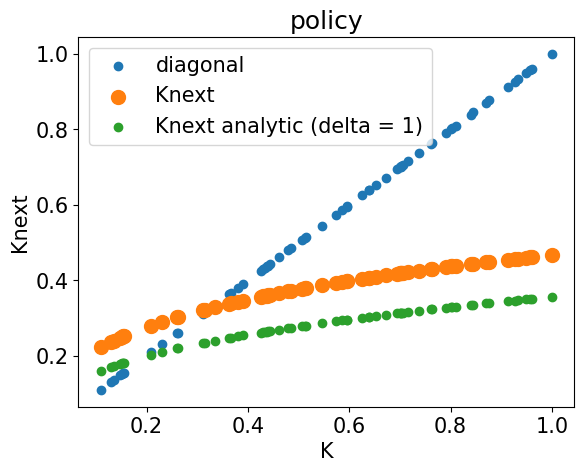

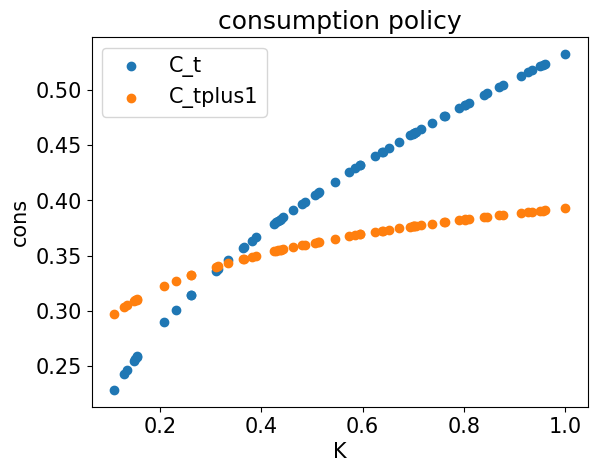

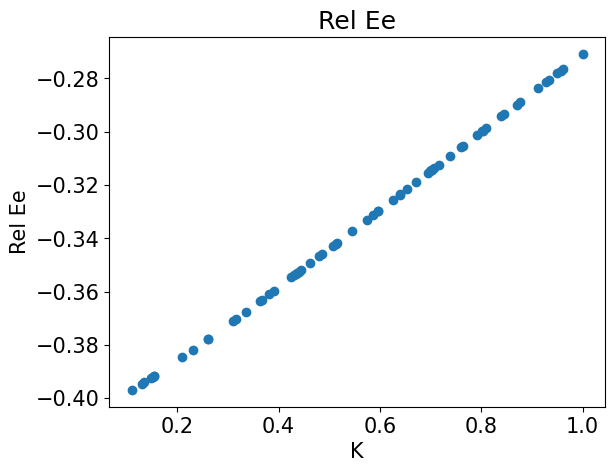

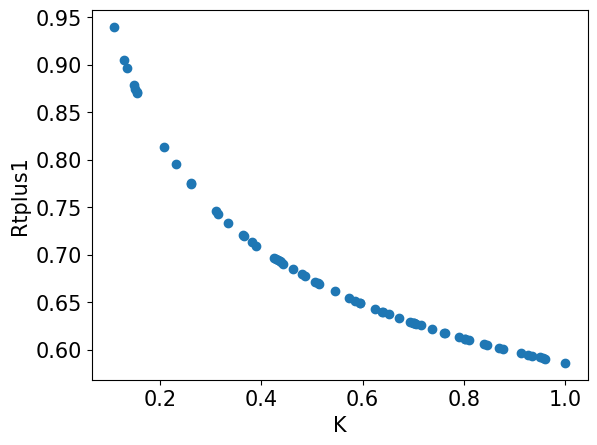

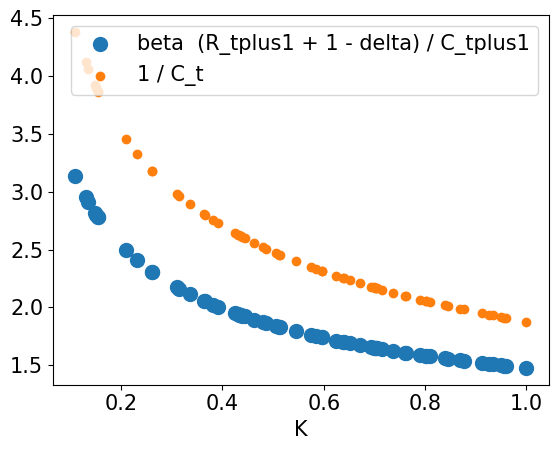

#=================================================================
episode = 100, loss [log10] = -2.7521450519561768
#=================================================================
episode = 200, loss [log10] = -4.756844997406006
#=================================================================
episode = 300, loss [log10] = -4.902477264404297
#=================================================================
episode = 400, loss [log10] = -5.326277256011963
#=================================================================
episode = 500, loss [log10] = -5.406925678253174


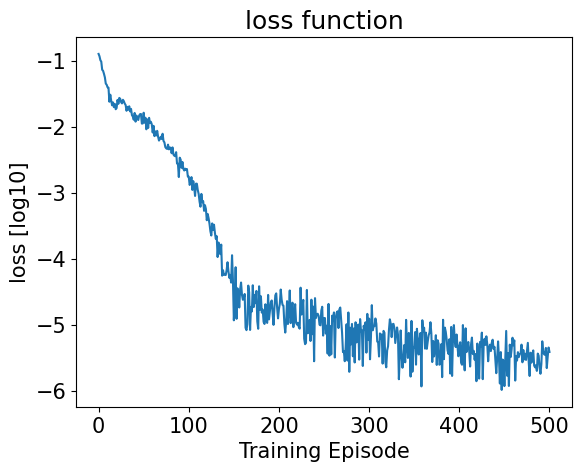

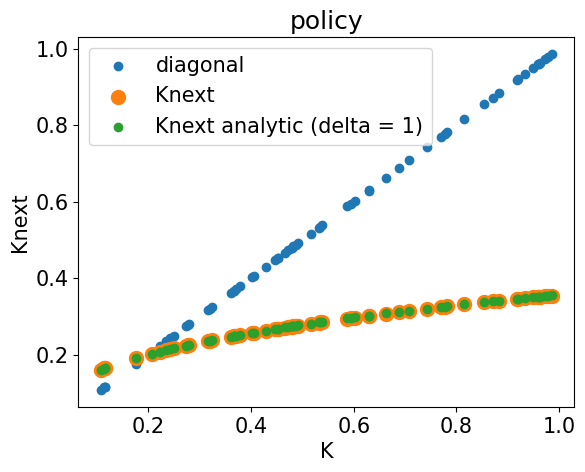

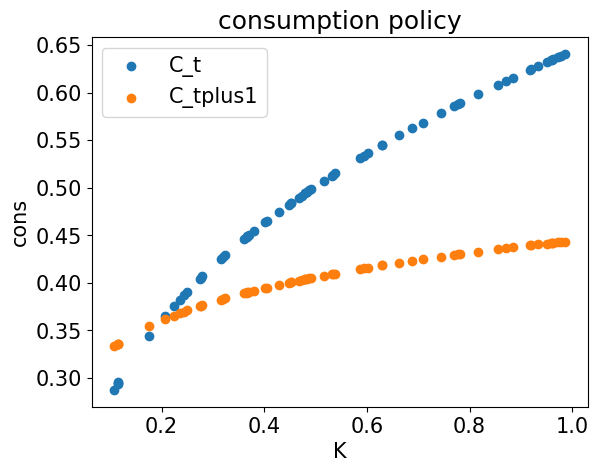

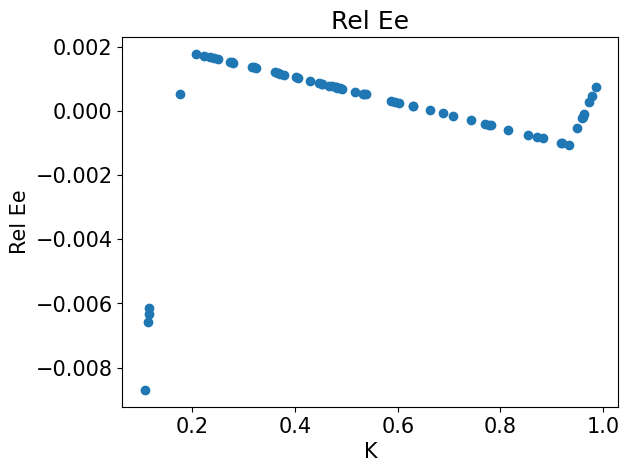

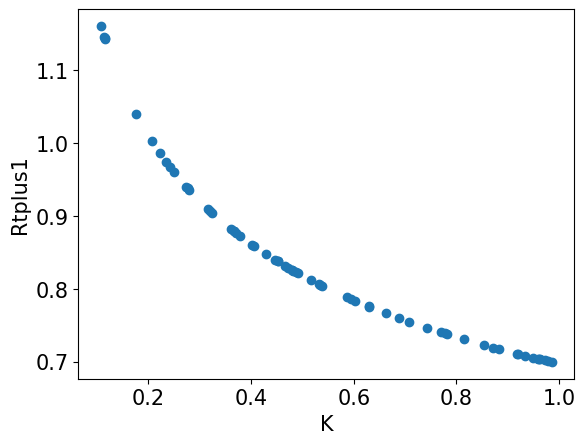

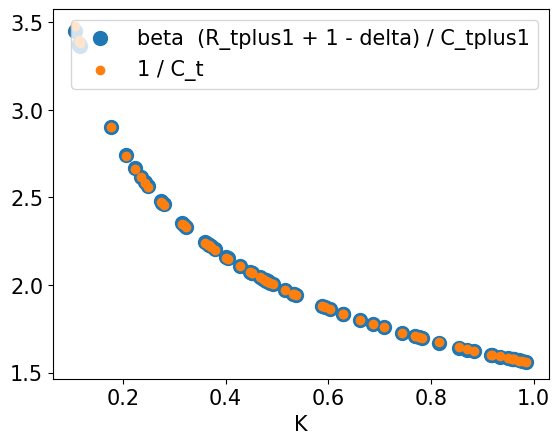

#=================================================================
episode = 600, loss [log10] = -6.4433465003967285
#=================================================================
episode = 700, loss [log10] = -6.8001484870910645
#=================================================================
episode = 800, loss [log10] = -6.6664347648620605
#=================================================================
episode = 900, loss [log10] = -6.387046813964844
#=================================================================
episode = 1000, loss [log10] = -7.779973030090332


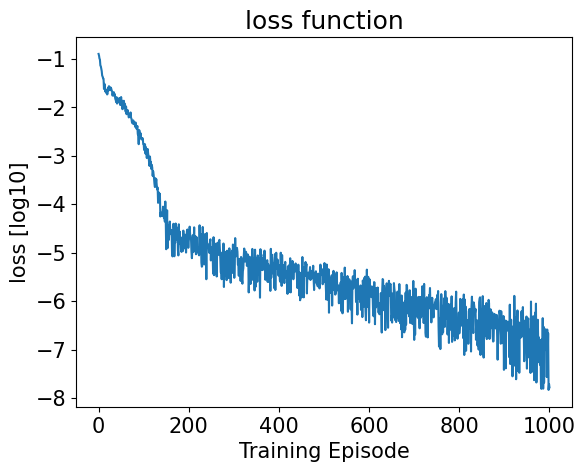

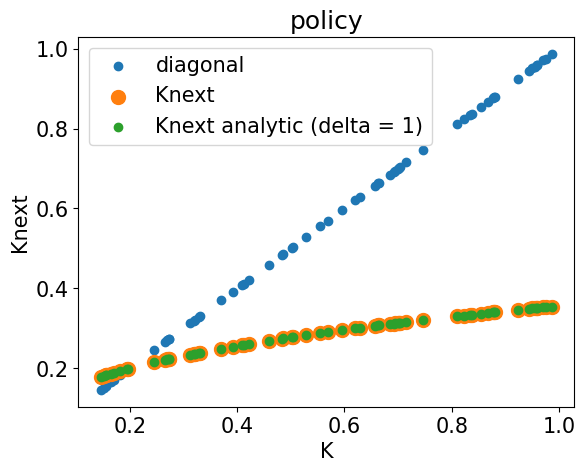

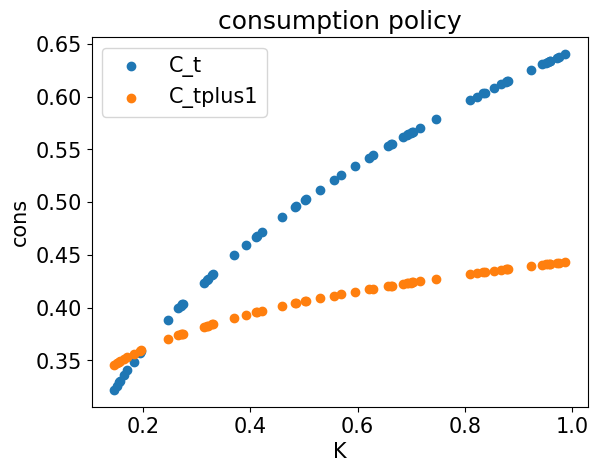

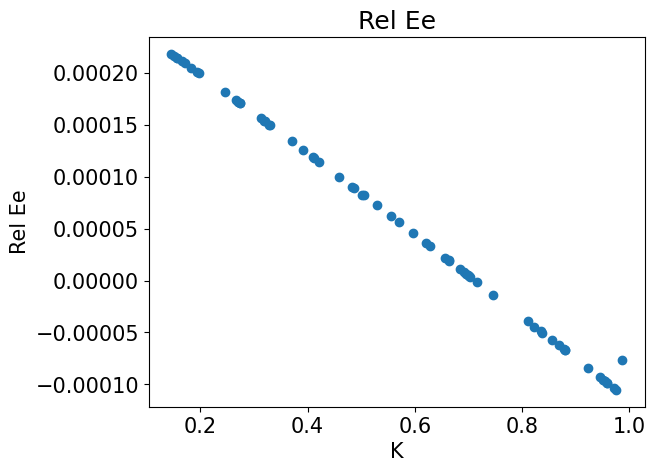

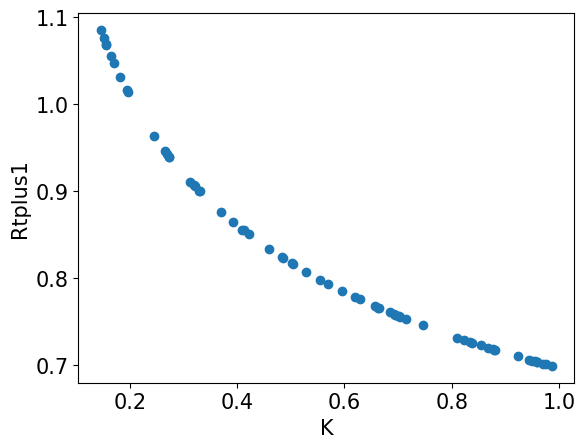

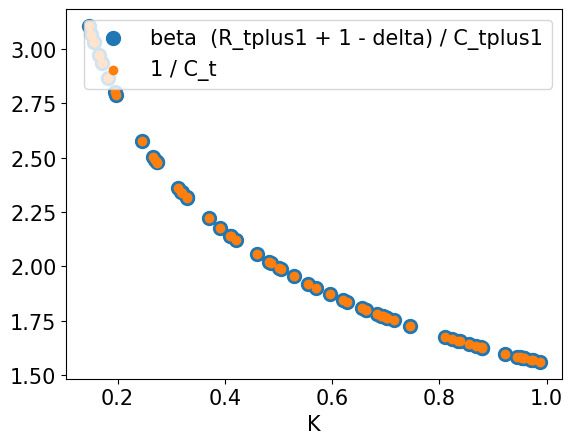

#=================================================================
episode = 1100, loss [log10] = -7.204279899597168
#=================================================================
episode = 1200, loss [log10] = -6.603235721588135
#=================================================================
episode = 1300, loss [log10] = -6.673098087310791
#=================================================================
episode = 1400, loss [log10] = -7.682140350341797
#=================================================================
episode = 1500, loss [log10] = -8.389164924621582


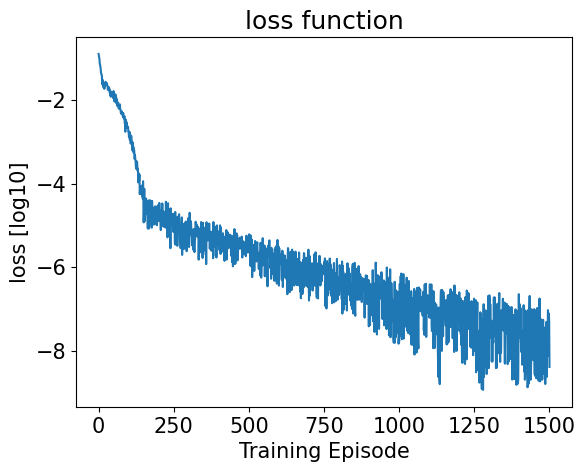

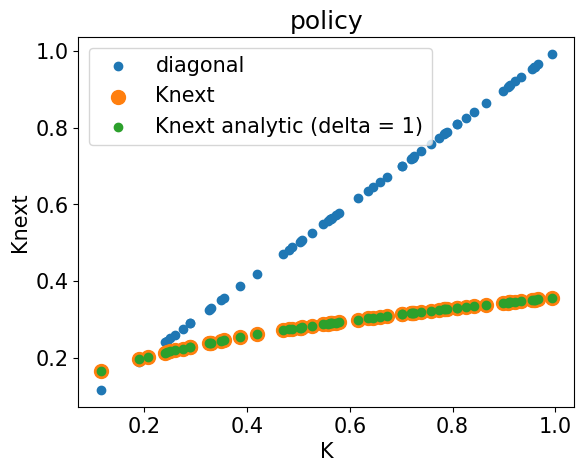

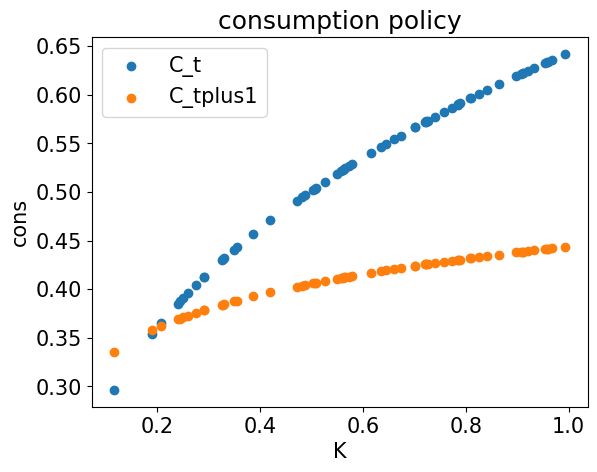

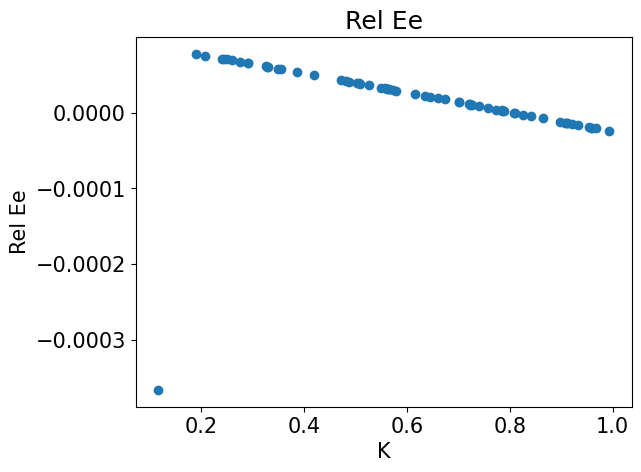

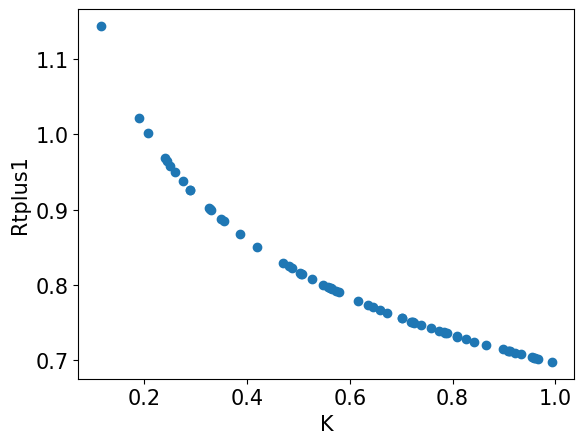

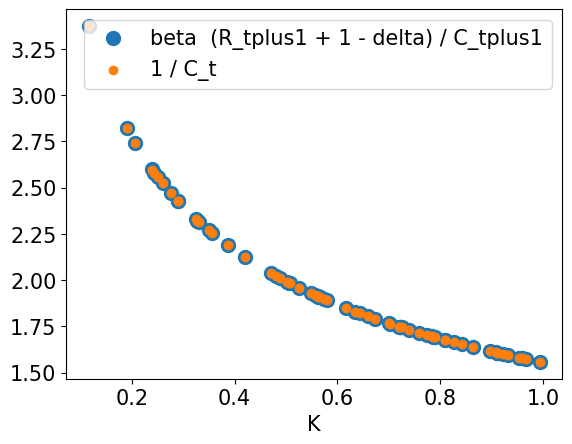

#=================================================================
episode = 1600, loss [log10] = -8.969791412353516
#=================================================================
episode = 1700, loss [log10] = -7.459362506866455
#=================================================================
episode = 1800, loss [log10] = -8.174952507019043
#=================================================================
episode = 1900, loss [log10] = -9.329837799072266
#=================================================================
episode = 2000, loss [log10] = -9.100020408630371


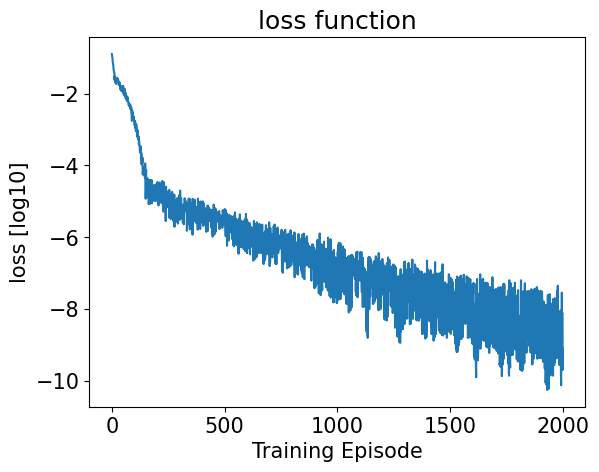

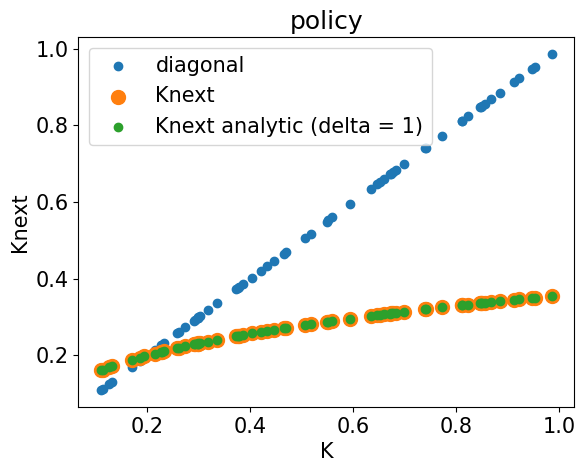

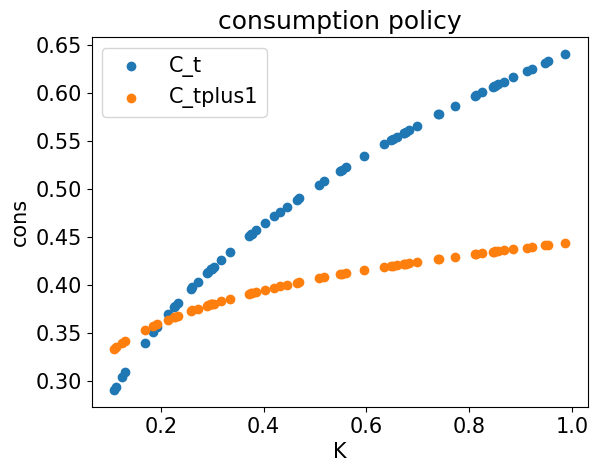

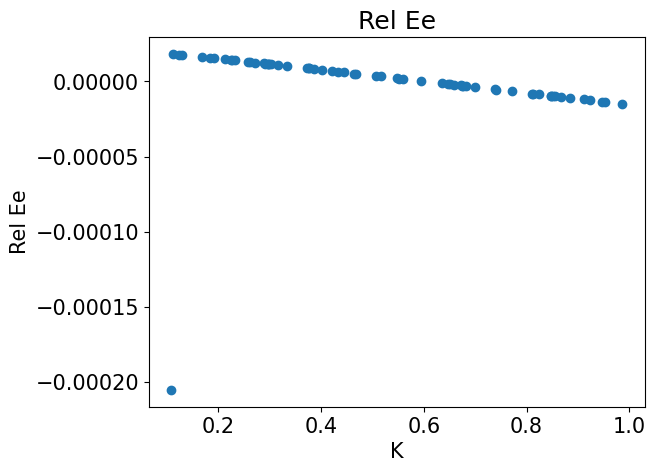

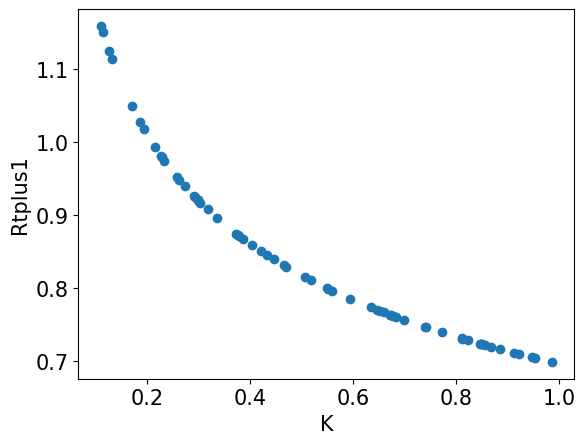

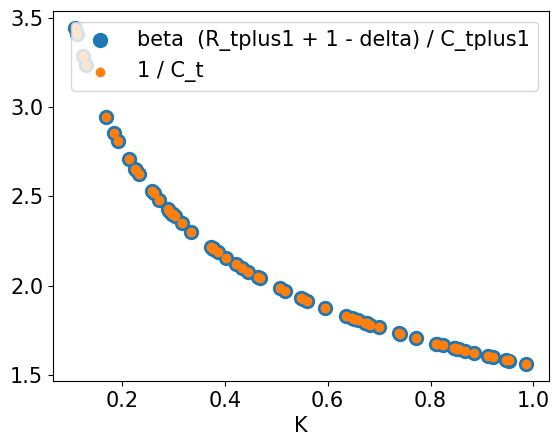

In [14]:
# Keep results for plotting
train_loss = []

num_episodes = 2001
n_data_per_epi = 64
k_lb = 0.10
k_ub = 1.0


for ep in range(num_episodes):
    # generate training data
    X = get_training_data(k_lb, k_ub, n_data_per_epi)

    # compute loss and gradients
    loss, grads = grad(X, nn)
    
    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % 100 == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % 500 == 0:
        cost, errREE, C_t, C_tplus1, K_tplus1, R_tplus1 = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], X[:, 0], label = "diagonal")
        plt.scatter(X[:, 0], K_tplus1[:, 0], s=100, label = "Knext")
        plt.scatter(X[:, 0], beta * alpha * X[:, 0] ** alpha, label = "Knext analytic (delta = 1)")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.scatter(X[:, 0], C_tplus1[:, 0], label="C_tplus1")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
       
        plt.xlabel("K")
        plt.ylabel("Rtplus1")
        plt.scatter(X[:, 0], R_tplus1[:, 0], label="R_tplus1")
        plt.show()
        plt.close()

        plt.xlabel("K")
        plt.scatter(X[:, 0], beta * (R_tplus1[:, 0] + 1. - delta)/C_tplus1[:, 0], s=100, label="beta  (R_tplus1 + 1 - delta) / C_tplus1")
        plt.scatter(X[:, 0], 1/C_t[:, 0], label="1 / C_t")
        plt.legend()
        plt.show()
        plt.close()
